 These are what I did:
 - Use different weights for the content and style layers.
     * content_weight_blend is the ratio of two used content layers
 
 - Use several style images.
 - Use different weights for the style layers.
     * for 100, 1000 and 100000

In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import IPython.display as ipyd
import scipy.misc
from libs import utils

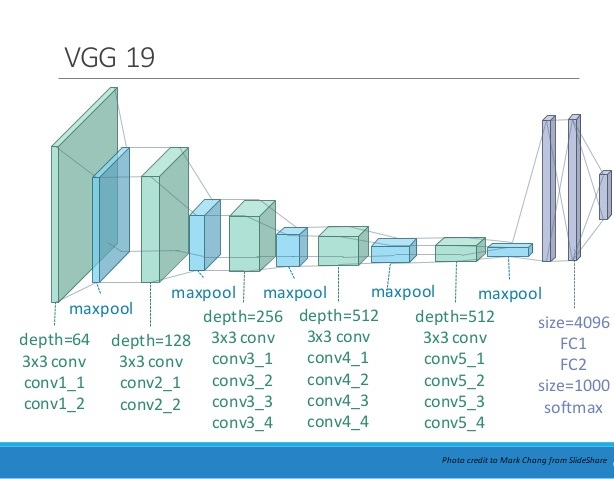

In [3]:
from IPython.display import Image
Image('vgg19.jpg')

In [4]:
from libs import vgg19

#start an interactive session
sess = tf.InteractiveSession()

images = tf.placeholder(tf.float32, [1, 224, 224, 3])
train_mode = tf.placeholder(tf.bool)

#load the model
vgg = vgg19.Vgg19()
vgg.build(images, train_mode)

sess.run(tf.global_variables_initializer())


In [5]:
g = tf.get_default_graph()
names = [op.name for op in g.get_operations()]
print('Sample of available operations: \n',names[:10])

Sample of available operations: 
 ['Placeholder', 'Placeholder_1', 'mul/y', 'mul', 'Const', 'split/split_dim', 'split', 'sub/y', 'sub', 'sub_1/y']


In [6]:


input_name = names[0] + ':0'
x = g.get_tensor_by_name(input_name)
x



<tf.Tensor 'Placeholder:0' shape=(1, 224, 224, 3) dtype=float32>

In [7]:
softmax = g.get_tensor_by_name(names[-2] + ':0')
#or use this: softmax = vgg.prob
softmax

<tf.Tensor 'prob:0' shape=(1, 1000) dtype=float32>

C:\Users\Bill\AppData\Local\conda\conda\envs\tf\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


image shape:  (224, 224, 3)


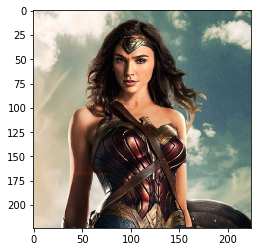

In [8]:
processed_img = utils.load_image('wonder-woman.jpg')

plt.imshow(processed_img)
print('image shape: ', processed_img.shape)

In [9]:


processed_img_4d = processed_img[np.newaxis]
print(processed_img_4d.shape)



(1, 224, 224, 3)


In [10]:
result = np.squeeze(softmax.eval(feed_dict={images: processed_img_4d, train_mode:False}))

In [11]:


W_vgg = vgg.data_dict['conv1_1'][0]
print(W_vgg.shape)



(3, 3, 3, 64)


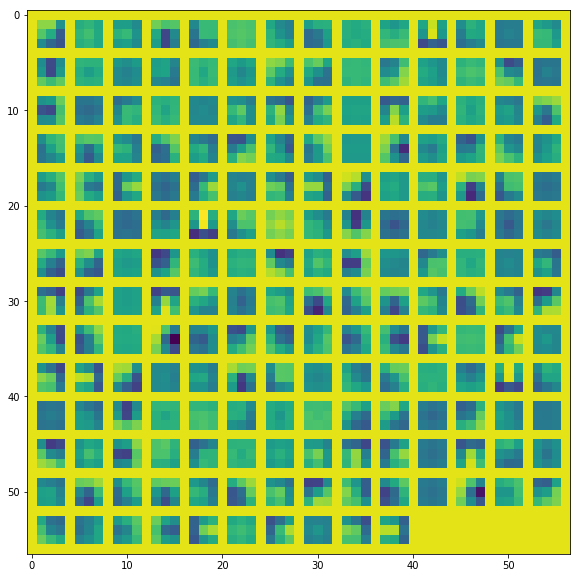

In [12]:


W_montage = utils.montage_filters(W_vgg)
plt.figure(figsize=(10,10))
plt.imshow(W_montage, interpolation='nearest')



In [13]:
vgg_conv1_1 = vgg.conv1_1.eval(feed_dict={images: processed_img_4d, train_mode:False}) 
vgg_conv2_1 = vgg.conv2_1.eval(feed_dict={images: processed_img_4d, train_mode:False})
vgg_conv5_1 = vgg.conv5_1.eval(feed_dict={images: processed_img_4d, train_mode:False})

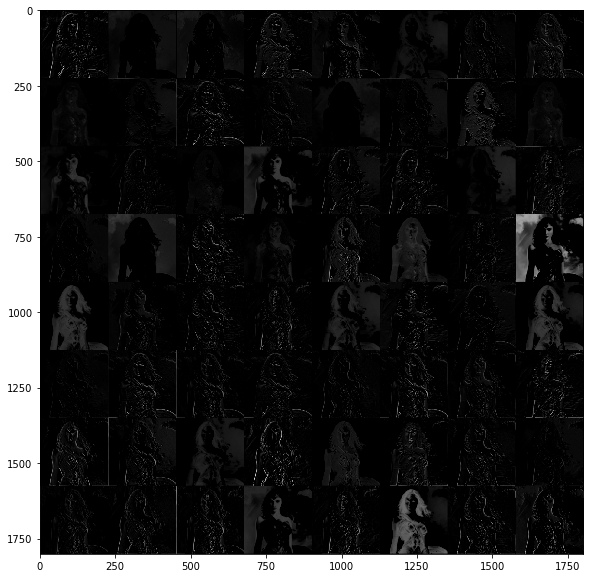

In [14]:
feature = vgg_conv1_1
montage = utils.montage_filters(np.rollaxis(np.expand_dims(feature[0], 3), 3, 2))
plt.figure(figsize=(10, 10))
plt.imshow(montage, cmap='gray')

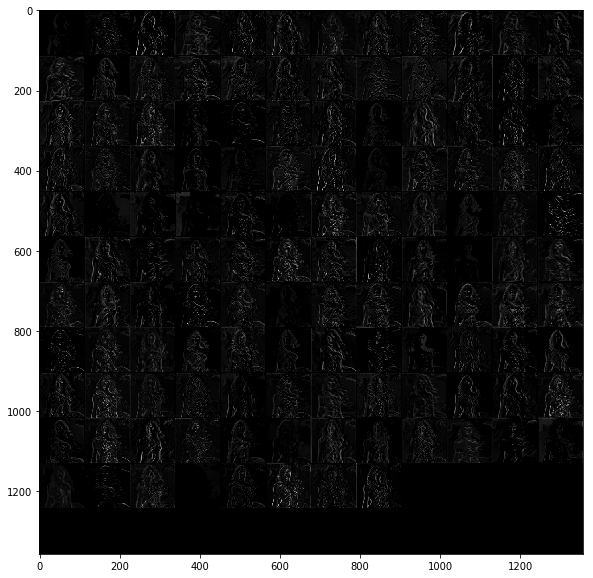

In [15]:
feature = vgg_conv2_1
montage = utils.montage_filters(np.rollaxis(np.expand_dims(feature[0], 3), 3, 2))
plt.figure(figsize=(10, 10))
plt.imshow(montage, cmap='gray')

In [16]:
layer_shape = tf.shape(feature).eval(feed_dict={images:processed_img_4d, train_mode:False})
print(layer_shape)

[  1 112 112 128]


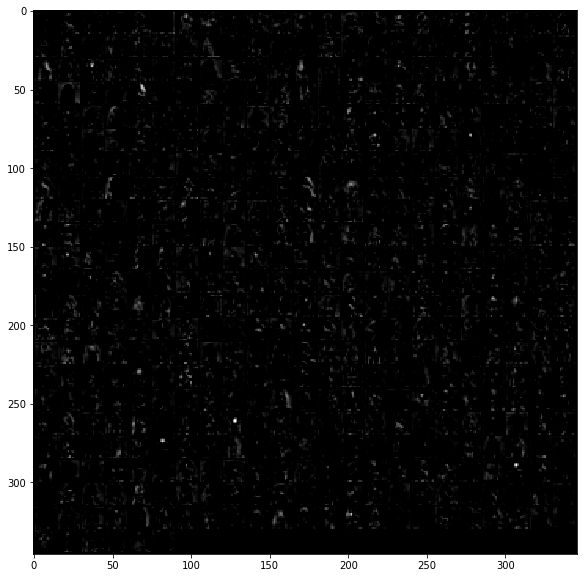

In [17]:


feature = vgg_conv5_1
montage = utils.montage_filters(np.rollaxis(np.expand_dims(feature[0], 3), 3, 2))
plt.figure(figsize=(10, 10))
plt.imshow(montage, cmap='gray')



In [18]:


feature = vgg.conv4_2
gradient = tf.gradients(tf.reduce_max(feature, axis=3), images)



In [19]:
res = sess.run(gradient, feed_dict={images: processed_img_4d, train_mode:True})[0]

In [20]:
#look at the range of values
print(np.min(res[0]), np.max(res[0]))

-9221.37 10603.7


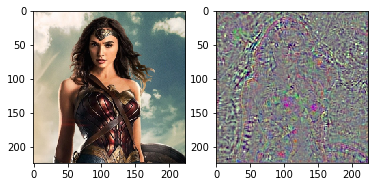

In [21]:
res_normalized = utils.normalize(res)

fig, axs = plt.subplots(1, 2)
plt.figure(figsize=(10,10))
axs[0].imshow(processed_img)
axs[1].imshow(res_normalized[0])

In [22]:
def compute_gradient_single_neuron(feature, neuron_i):
  '''visualize a single neuron in a layer, with neuron_i specifying the index of the neuron'''
  gradient = tf.gradients(tf.reduce_mean(feature[:, :, :, neuron_i]), images)
  res = sess.run(gradient, feed_dict={images: processed_img_4d, train_mode: False})[0]
  return res

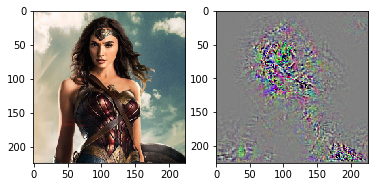

In [23]:


gradient = compute_gradient_single_neuron(vgg.conv5_2, 77)
gradient_norm = utils.normalize(gradient)
montage = utils.montage(np.array(gradient_norm))
fig, axs = plt.subplots(1, 2)
axs[0].imshow(processed_img)
axs[1].imshow(montage)



In [24]:
import os
content_directory = 'contents/'
style_directory = 'styles/'

# This is the directory to store the final stylized images
output_directory = 'image_output/'
if not os.path.exists(output_directory):
  os.makedirs(output_directory)
    
# This is the directory to store the half-done images during the training.
checkpoint_directory = 'checkpoint_output/'
if not os.path.exists(checkpoint_directory):
  os.makedirs(checkpoint_directory)
    
content_path = os.path.join(content_directory, 'wonder-woman.jpg')
style_path = os.path.join(style_directory, 'starry-night.jpg')
output_path = os.path.join(output_directory, 'wonder-woman-starry-night-iteration-1000.jpg')

# please notice that the checkpoint_images_path has to contain %s in the file_name
checkpoint_path = os.path.join(checkpoint_directory, 'wonder-woman-starry-night-iteration-1000-%s.jpg')

In [25]:


content_image = utils.imread(content_path)

# You can pass several style images as a list, but let's use just one for now.
style_images = [utils.imread(style_path)]



In [26]:
import tensorflow as tf
import numpy as np
import scipy.io
import os

VGG_MEAN = [103.939, 116.779, 123.68]

VGG19_LAYERS = (
  'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

  'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

  'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
  'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

  'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
  'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

  'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
'relu5_3', 'conv5_4', 'relu5_4'
)


def net_preloaded(input_image, pooling):
  data_dict = np.load('libs/vgg19.npy', encoding='latin1').item()
  net = {}
  current = input_image
  for i, name in enumerate(VGG19_LAYERS):
    kind = name[:4]
    if kind == 'conv':
      kernels = get_conv_filter(data_dict, name)
      # kernels = np.transpose(kernels, (1, 0, 2, 3))

      bias = get_bias(data_dict, name)
      # matconvnet: weights are [width, height, in_channels, out_channels]
      # tensorflow: weights are [height, width, in_channels, out_channels]

      # bias = bias.reshape(-1)
      current = conv_layer(current, kernels, bias)
    elif kind == 'relu':
      current = tf.nn.relu(current)
    elif kind == 'pool':
      current = pool_layer(current, pooling)
    
    net[name] = current

  assert len(net) == len(VGG19_LAYERS)
  return net

def conv_layer(input, weights, bias):
  conv = tf.nn.conv2d(input, weights, strides=(1, 1, 1, 1), padding='SAME')
  return tf.nn.bias_add(conv, bias)


def pool_layer(input, pooling):
  if pooling == 'avg':
    return tf.nn.avg_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
            padding='SAME')
  else:
    return tf.nn.max_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
            padding='SAME')

# before we feed the image into the network, we preprocess it by 
# extracting the mean_pixel from it.
def preprocess(image):
  return image - VGG_MEAN

# remember to unprocess it before you plot it out and save it.
def unprocess(image):
  return image + VGG_MEAN

def get_conv_filter(data_dict, name):
  return tf.constant(data_dict[name][0], name="filter")

def get_bias(data_dict, name):
  return tf.constant(data_dict[name][1], name="biases")

In [48]:
import tensorflow as tf
import numpy as np
from functools import reduce
from PIL import Image

# feel free to try different layers
CONTENT_LAYERS = ('relu4_2', 'relu5_2')
STYLE_LAYERS = ('relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1')

VGG_MEAN = [103.939, 116.779, 123.68]

def stylize(content, styles, network_path='libs/imagenet-vgg-verydeep-19.mat', 
            iterations=1000, content_weight=5e0, content_weight_blend=0.5, style_weight=5e2, 
            style_layer_weight_exp=1,style_blend_weights=None, tv_weight=100,
            learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
            print_iterations=100, checkpoint_iterations=100, checkpoint_path=None,
            output_path=None):
    
    
  shape = (1,) + content.shape                             #content image shape : (1,433,770,3)
  style_shapes = [(1,) + style.shape for style in styles]  #style image shape : (1,600,800,3)
  content_features = {}
  style_features = [{} for _ in styles]

    
  # scale the importance of each style layers according to their depth. 
  # (deeper layers are more important if style_layers_weights > 1 (default = 1))
  layer_weight = 1.0
  style_layers_weights = {}                                # weight for different network layers
  for style_layer in STYLE_LAYERS:                                    
    style_layers_weights[style_layer] = layer_weight       #'relu1_1','relu2_1',...,'relu5_1'
    layer_weight *= style_layer_weight_exp                 # 1.0

        
  # normalize style layer weights
  layer_weights_sum = 0
  for style_layer in STYLE_LAYERS:                         #'relu1_1',..., 'relu5_1'
    layer_weights_sum += style_layers_weights[style_layer] # 5.0
  for style_layer in STYLE_LAYERS:
    style_layers_weights[style_layer] /= layer_weights_sum

        
  # FEATURE MAPS FROM CONTENT IMAGE
  # compute the feature map of the content image by feeding it into the network
  #the output net contains the features of each content layer
  g = tf.Graph()
  with g.as_default(), tf.Session() as sess:
    image = tf.placeholder('float', shape=shape)

    net = net_preloaded(image, pooling)             # {'conv1_1':Tensor,relu1_1:Tensor...}
    content_pre = np.array([preprocess(content)])   # (1,433,770,3) subtract the mean pixel
    for layer in CONTENT_LAYERS:                    #'relu4_2', 'relu5_2'
      content_features[layer] = net[layer].eval(feed_dict={image: content_pre})  

            
  # FEATURE MAPS (GRAM MATRICES) FROM STYLE IMAGE
  # compute style features of the style image by feeding it into the network
  # and calculate the gram matrix
  for i in range(len(styles)):
    g = tf.Graph()
    with g.as_default(), tf.Session() as sess:
      image = tf.placeholder('float', shape=style_shapes[i])
      net = net_preloaded(image, pooling)                           
      style_pre = np.array([preprocess(styles[i])])
      for layer in STYLE_LAYERS:              #'relu1_1', 'relu2_1',..., 'relu5_1'
        features = net[layer].eval(feed_dict={image: style_pre})  # relu_1:(1,600,800,64)
        features = np.reshape(features, (-1, features.shape[3]))  # (480000, 64)
        gram = np.matmul(features.T, features) / features.size    # (64,64)
        style_features[i][layer] = gram

                
  # make stylized image using backpropogation
  with tf.Graph().as_default():

    # Generate a random image (the output image) with the same shape as the content image
    initial = tf.random_normal(shape) * 0.256  
    image = tf.Variable(initial)
    net = net_preloaded(image, pooling)
    

    # CONTENT LOSS
    # we can adjust the weight of each content layers
    # content_weight_blend is the ratio of two used content layers in this example
    content_layers_weights = {}
    content_layers_weights['relu4_2'] = content_weight_blend 
    content_layers_weights['relu5_2'] = 1.0 - content_weight_blend      

    content_loss = 0
    content_losses = []
    for content_layer in CONTENT_LAYERS:
      # Use MSE as content losses
      # content weight is the coefficient for content loss
      content_losses.append(content_layers_weights[content_layer] * content_weight * 
              (2 * tf.nn.l2_loss(net[content_layer] - content_features[content_layer]) /
              content_features[content_layer].size))
    content_loss += reduce(tf.add, content_losses)



    # STYLE LOSS
    # We can specify different weight for different style images
    # style_layers_weights => weight for different network layers
    # style_blend_weights => weight between different style images

    if style_blend_weights is None:
      style_blend_weights = [1.0/len(styles) for _ in styles]
    else:
      total_blend_weight = sum(style_blend_weights)
      # normalization
      style_blend_weights = [weight/total_blend_weight
                             for weight in style_blend_weights]


    style_loss = 0
    # iterate to calculate style loss with multiple style images
    for i in range(len(styles)):
      style_losses = []
      for style_layer in STYLE_LAYERS:             # e.g. relu1_1
        layer = net[style_layer]                   # relu1_1 of output image:(1,433,770,64)
        _, height, width, number = map(lambda i: i.value, layer.get_shape())  
        size = height * width * number
        feats = tf.reshape(layer, (-1, number))    # (333410,64)

        # Gram matrix for the features in relu1_1 of the output image.
        gram = tf.matmul(tf.transpose(feats), feats) / size
        # Gram matrix for the features in relu1_1 of the style image
        style_gram = style_features[i][style_layer]   

        # Style loss is the MSE for the difference of the 2 Gram matrices
        style_losses.append(style_layers_weights[style_layer] * 2 * 
                            tf.nn.l2_loss(gram - style_gram) / style_gram.size)
      style_loss += style_weight * style_blend_weights[i] * reduce(tf.add, style_losses)


    # TOTAL VARIATION LOSS  
    # Total variation denoising to do smoothing; cost to penalize neighboring pixel
    # not used by the original paper by Gatys et al
    # According to the paper Mahendran, Aravindh, and Andrea Vedaldi. "Understanding deep 
    # image representations by inverting them."
    # Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition. 2015.
    tv_y_size = _tensor_size(image[:,1:,:,:])
    tv_x_size = _tensor_size(image[:,:,1:,:])
    tv_loss = tv_weight * 2 * (
      (tf.nn.l2_loss(image[:,1:,:,:] - image[:,:shape[1]-1,:,:]) /
          tv_y_size) +
      (tf.nn.l2_loss(image[:,:,1:,:] - image[:,:,:shape[2]-1,:]) /
          tv_x_size))


    #OVERALL LOSS
    loss = content_loss + style_loss + tv_loss

    train_step = tf.train.AdamOptimizer(learning_rate, beta1, beta2, epsilon).minimize(loss)

    def print_progress():
      print('     iteration: %d\n' % i)
      print('  content loss: %g\n' % content_loss.eval())
      print('    style loss: %g\n' % style_loss.eval())
      print('       tv loss: %g\n' % tv_loss.eval())
      print('    total loss: %g\n' % loss.eval())

    def imsave(path, img):
      img = np.clip(img, 0, 255).astype(np.uint8)
      Image.fromarray(img).save(path, quality=95)

    
    
    # TRAINING
    best_loss = float('inf')
    best = None
    
    with tf.Session() as sess:
        
      sess.run(tf.global_variables_initializer())
    
      if (print_iterations and print_iterations != 0):
        print_progress()
        
      for i in range(iterations):

        train_step.run()

        last_step = (i == iterations - 1)
        if last_step or (print_iterations and i % print_iterations == 0):
          print_progress()

        # store output and checkpoint images
        if (checkpoint_iterations and i % checkpoint_iterations == 0) or last_step:
          this_loss = loss.eval()
          if this_loss < best_loss:
            best_loss = this_loss
            best = image.eval()

          img_out = unprocess(best.reshape(shape[1:]))

          output_file = None
          if not last_step:
            if checkpoint_path:
                output_file = checkpoint_path % i
          else:
            output_file = output_path
#           print(type(output_file))
          if output_file:
            imsave(output_file, img_out)
            
  print("finish stylizing.")



def _tensor_size(tensor):
  from operator import mul
  return reduce(mul, (d.value for d in tensor.get_shape()), 1)

In [60]:


checkpoint_path=None
output_path='image_output/wonder-woman-starry-night-tvweight-100000.jpg'
style_path = os.path.join(style_directory, 'starry-night.jpg')
style_images = [utils.imread(style_path)]

stylize(content_image, style_images, iterations=1000,
        content_weight=10e0, content_weight_blend=1, style_weight=10e2, 
        style_layer_weight_exp=1, style_blend_weights=None, tv_weight=100000,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)



     iteration: 0

  content loss: 767453

    style loss: 3.03279e+06

       tv loss: 26208

    total loss: 3.82645e+06

     iteration: 0

  content loss: 738468

    style loss: 2.74396e+06

       tv loss: 3.4903e+07

    total loss: 3.83854e+07

     iteration: 100

  content loss: 529955

    style loss: 1.66316e+06

       tv loss: 416633

    total loss: 2.60975e+06

     iteration: 200

  content loss: 441832

    style loss: 1.39643e+06

       tv loss: 305208

    total loss: 2.14347e+06

     iteration: 300

  content loss: 424516

    style loss: 1.30043e+06

       tv loss: 311726

    total loss: 2.03667e+06

     iteration: 400

  content loss: 414625

    style loss: 1.25096e+06

       tv loss: 316912

    total loss: 1.9825e+06

     iteration: 500

  content loss: 408744

    style loss: 1.22188e+06

       tv loss: 322490

    total loss: 1.95311e+06

     iteration: 600

  content loss: 405162

    style loss: 1.20398e+06

       tv loss: 325836

    total loss:

In [42]:
from IPython.display import Image as pic_print

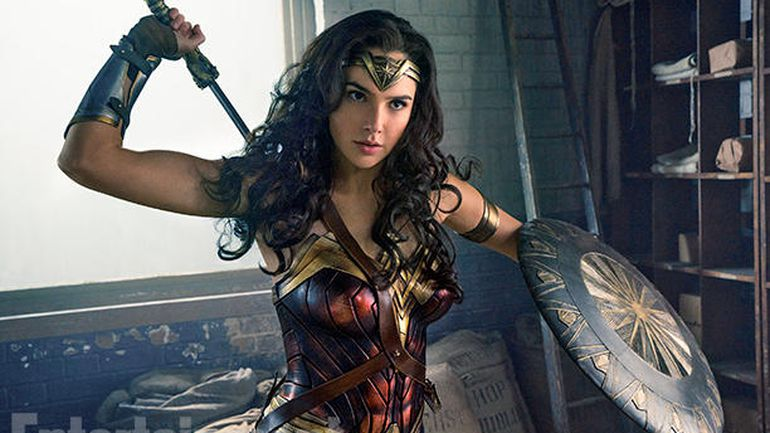

In [57]:
pic_printintprint(filename=content_path)

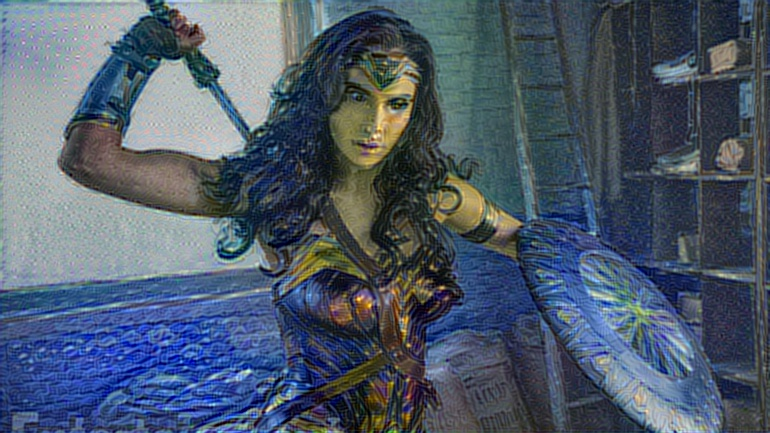

In [62]:
pic_print(filename='image_output/wonder-woman-starry-night-tvweight-100.jpg')

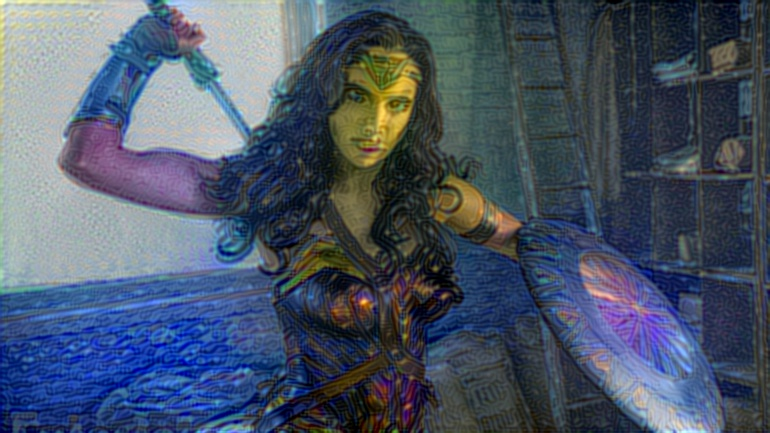

In [66]:
pic_print(filename='image_output/wonder-woman-starry-night-tvweight-1000.jpg')

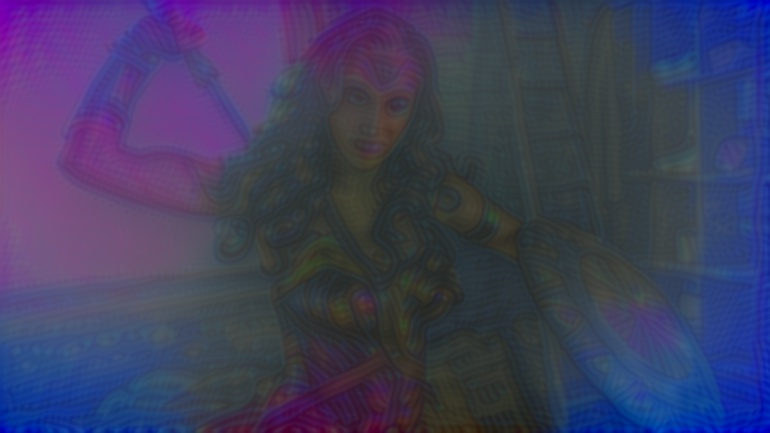

In [63]:
pic_print(filename=output_path)

In [64]:
checkpoint_path=None
output_path='image_output/wonder-woman-starry-night-tvweight-100-layer.jpg'
style_path = os.path.join(style_directory, 'starry-night.jpg')
style_images = [utils.imread(style_path)]

stylize(content_image, style_images, iterations=1000,
        content_weight=5e0, content_weight_blend=0.7, style_weight=5e2, 
        style_layer_weight_exp=10, style_blend_weights=None, tv_weight=100,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)


     iteration: 0

  content loss: 268774

    style loss: 344460

       tv loss: 26.2055

    total loss: 613260

     iteration: 0

  content loss: 256441

    style loss: 303138

       tv loss: 15820.3

    total loss: 575400

     iteration: 100

  content loss: 52710.3

    style loss: 16648.5

       tv loss: 17215.8

    total loss: 86574.5

     iteration: 200

  content loss: 49272.9

    style loss: 16437.2

       tv loss: 15452.8

    total loss: 81162.9

     iteration: 300

  content loss: 47456.2

    style loss: 17680.3

       tv loss: 14834.6

    total loss: 79971.1

     iteration: 400

  content loss: 47030.3

    style loss: 19332.7

       tv loss: 14137.6

    total loss: 80500.6

     iteration: 500

  content loss: 46870

    style loss: 17888.7

       tv loss: 15352.5

    total loss: 80111.2

     iteration: 600

  content loss: 47416.2

    style loss: 16907.1

       tv loss: 13752.2

    total loss: 78075.5

     iteration: 700

  content loss: 48305.6

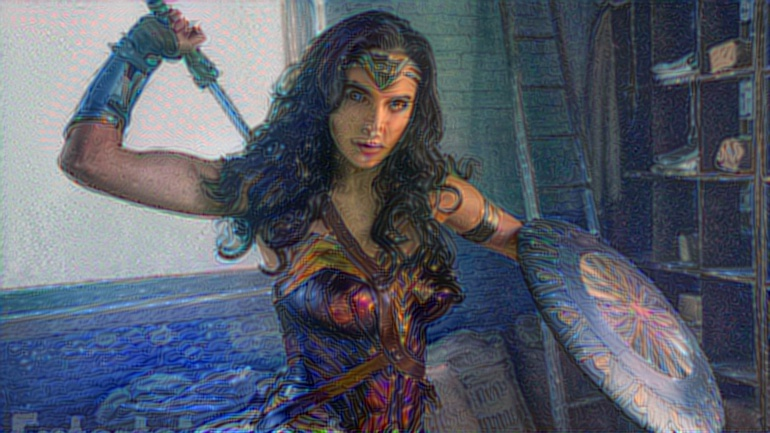

In [65]:
pic_print(filename=output_path)

In [47]:
checkpoint_path=None
output_path='image_output/wonder-woman-the-gleaners-100.jpg'

style_path = os.path.join(style_directory, 'the-gleaners.jpg')
style_images = [utils.imread(style_path)]

stylize(content_image, style_images, iterations=1000,
        content_weight=5e0, content_weight_blend=1, style_weight=5e2, 
        style_layer_weight_exp=1, style_blend_weights=None, tv_weight=100,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)


     iteration: 0

  content loss: 383747

    style loss: 998180

       tv loss: 26.2424

    total loss: 1.38195e+06

     iteration: 0

  content loss: 367549

    style loss: 875116

       tv loss: 15887.8

    total loss: 1.25855e+06

<class 'NoneType'>
     iteration: 100

  content loss: 100193

    style loss: 42315.5

       tv loss: 17372.2

    total loss: 159880

<class 'NoneType'>
     iteration: 200

  content loss: 84948.9

    style loss: 25744.1

       tv loss: 12653.5

    total loss: 123346

<class 'NoneType'>
     iteration: 300

  content loss: 83235.1

    style loss: 26882

       tv loss: 12279.4

    total loss: 122396

<class 'NoneType'>
     iteration: 400

  content loss: 85524.8

    style loss: 36908.9

       tv loss: 12452.4

    total loss: 134886

<class 'NoneType'>
     iteration: 500

  content loss: 92786.8

    style loss: 33088.2

       tv loss: 13984.6

    total loss: 139860

<class 'NoneType'>
     iteration: 600

  content loss: 83461.4

 

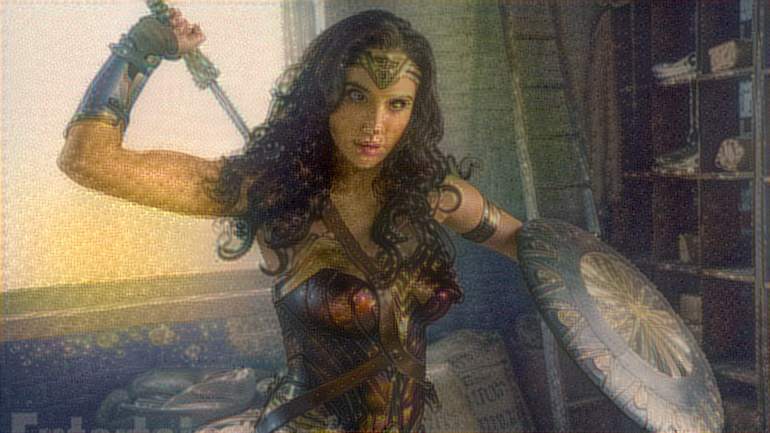

In [49]:
pic_print(filename=output_path)

In [50]:
checkpoint_path=None
output_path='image_output/wonder-woman-dot-paint-100.jpg'
style_path = os.path.join(style_directory, 'A_Sunday_on_La_Grande_Jatte.jpg')
style_images = [utils.imread(style_path)]

stylize(content_image, style_images, iterations=1000,
        content_weight=5e0, content_weight_blend=1, style_weight=5e2, 
        style_layer_weight_exp=1, style_blend_weights=None, tv_weight=100,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)


     iteration: 0

  content loss: 383766

    style loss: 820664

       tv loss: 26.2354

    total loss: 1.20446e+06

     iteration: 0

  content loss: 366743

    style loss: 653057

       tv loss: 15557.2

    total loss: 1.03536e+06

     iteration: 100

  content loss: 94215.7

    style loss: 26018.1

       tv loss: 24112.8

    total loss: 144347

     iteration: 200

  content loss: 91447.7

    style loss: 24562

       tv loss: 22176

    total loss: 138186

     iteration: 300

  content loss: 92302.5

    style loss: 24791.7

       tv loss: 21990.6

    total loss: 139085

     iteration: 400

  content loss: 87511.3

    style loss: 29439.2

       tv loss: 21327.8

    total loss: 138278

     iteration: 500

  content loss: 90157.9

    style loss: 27724.7

       tv loss: 22122.1

    total loss: 140005

     iteration: 600

  content loss: 88594.6

    style loss: 25188.6

       tv loss: 21353.8

    total loss: 135137

     iteration: 700

  content loss: 88443

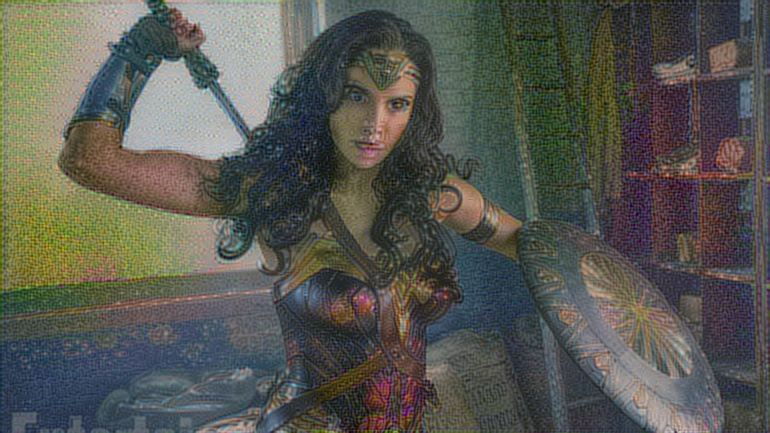

In [51]:
pic_print(filename=output_path)

In [52]:
checkpoint_path=None
output_path='image_output/wonder-woman-land-of-lustrous-100.jpg'
style_path = os.path.join(style_directory, 'land-of-lustrous-08.jpg')
style_images = [utils.imread(style_path)]

stylize(content_image, style_images, iterations=1000,
        content_weight=5e0, content_weight_blend=1, style_weight=5e2, 
        style_layer_weight_exp=1, style_blend_weights=None, tv_weight=100,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)

     iteration: 0

  content loss: 383749

    style loss: 3.25619e+06

       tv loss: 26.144

    total loss: 3.63996e+06

     iteration: 0

  content loss: 368417

    style loss: 3.01546e+06

       tv loss: 15746.9

    total loss: 3.39963e+06

     iteration: 100

  content loss: 210163

    style loss: 71423.2

       tv loss: 17888.1

    total loss: 299475

     iteration: 200

  content loss: 184578

    style loss: 44870.3

       tv loss: 15668.3

    total loss: 245116

     iteration: 300

  content loss: 173053

    style loss: 42267.2

       tv loss: 14743.2

    total loss: 230063

     iteration: 400

  content loss: 222565

    style loss: 327237

       tv loss: 22076.2

    total loss: 571878

     iteration: 500

  content loss: 158438

    style loss: 42371.8

       tv loss: 13806.8

    total loss: 214617

     iteration: 600

  content loss: 179676

    style loss: 54305.6

       tv loss: 17612.1

    total loss: 251594

     iteration: 700

  content loss:

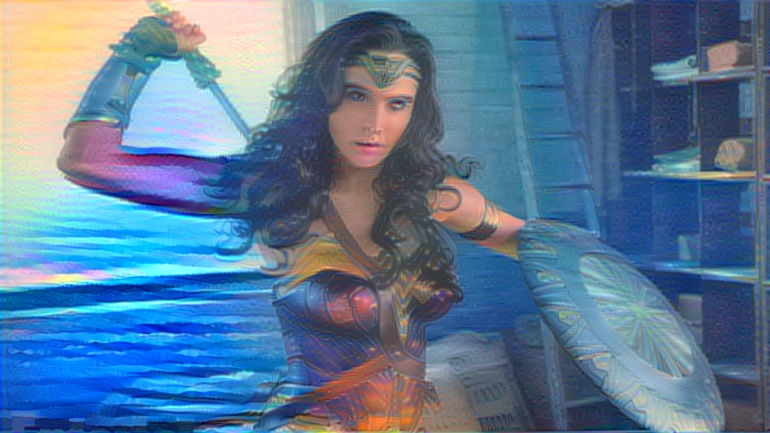

In [53]:
pic_print(filename=output_path)

In [54]:
checkpoint_path=None
output_path='image_output/wonder-woman-vinland-saga-100.jpg'
style_path = os.path.join(style_directory, 'vinland-saga.jpg')
style_images = [utils.imread(style_path)]

stylize(content_image, style_images, iterations=1000,
        content_weight=5e0, content_weight_blend=1, style_weight=5e2, 
        style_layer_weight_exp=1, style_blend_weights=None, tv_weight=100,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)

     iteration: 0

  content loss: 383771

    style loss: 4.8412e+06

       tv loss: 26.248

    total loss: 5.22499e+06

     iteration: 0

  content loss: 367121

    style loss: 4.52841e+06

       tv loss: 16072.1

    total loss: 4.9116e+06

     iteration: 100

  content loss: 211961

    style loss: 110084

       tv loss: 110616

    total loss: 432662

     iteration: 200

  content loss: 134662

    style loss: 50433.5

       tv loss: 107062

    total loss: 292157

     iteration: 300

  content loss: 116908

    style loss: 47169.5

       tv loss: 104774

    total loss: 268851

     iteration: 400

  content loss: 111520

    style loss: 56831.8

       tv loss: 104324

    total loss: 272676

     iteration: 500

  content loss: 104600

    style loss: 45877.3

       tv loss: 102224

    total loss: 252701

     iteration: 600

  content loss: 96355.5

    style loss: 43386.1

       tv loss: 101609

    total loss: 241351

     iteration: 700

  content loss: 95422.

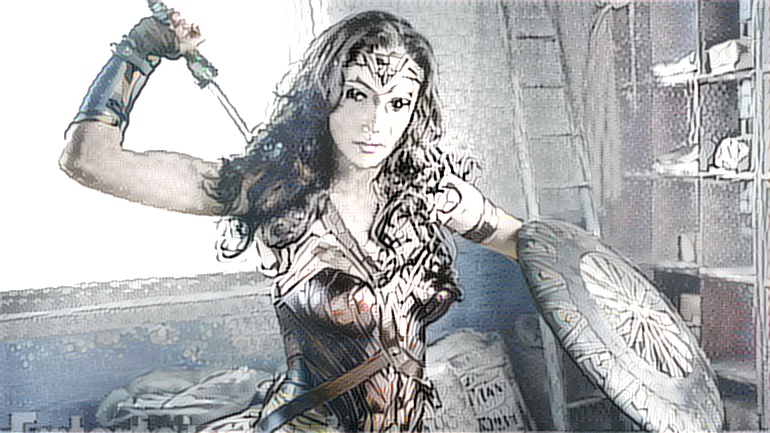

In [55]:
pic_print(filename=output_path)